**Set-up(The following installations are adapted for Google Colab)** ⛳

In [2]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark

--2023-11-05 02:53:28--  https://downloads.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388341449 (370M) [application/x-gzip]
Saving to: ‘spark-3.4.1-bin-hadoop3.tgz’

spark-3.4.1-bin-had 100%[===================>] 370.35M  20.2MB/s    in 19s     

2023-11-05 02:53:48 (19.1 MB/s) - ‘spark-3.4.1-bin-hadoop3.tgz’ saved [388341449/388341449]



In [3]:
# Set up environment paths for Java and Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

In [4]:
!pip install pyspark

In [5]:
# Only import pyspark after findSpark.init()
import findspark
findspark.init()

from pyspark.sql import SparkSession, functions, types
import sys
assert sys.version_info >= (3, 5) # make sure we have Python 3.5

spark = SparkSession.builder.appName('Steam review analysis').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext

**Data Cleaning & Preparation:** ⛳





> *Read train and test dataset*








In [7]:
game_reviews_schema = types.StructType([
    types.StructField('Review', types.StringType()),
    types.StructField('Translated_Review', types.StringType()),
    types.StructField('Cleaned_Review', types.StringType()),
    types.StructField('Sentiment_Score', types.IntegerType()),
    types.StructField('Game_Name', types.StringType()),
])
game_reviews_train = spark.read.csv('datasets/Train.csv', header=True, schema=game_reviews_schema)
game_reviews_train.show(5)

game_reviews_test = spark.read.csv('datasets/Test.csv', header=True, schema=game_reviews_schema)
game_reviews_test.show(5)

+--------------------+--------------------+--------------------+---------------+--------------+
|              Review|   Translated_Review|      Cleaned_Review|Sentiment_Score|     Game_Name|
+--------------------+--------------------+--------------------+---------------+--------------+
|It's full of bots...|It's full of bots...|s bots years grea...|              1|Team Fortress2|
|                 Yes|                 Yes|                 yes|              1|         GTA V|
|             Moogus.|             Moogus.|              moogus|              1|Team Fortress2|
|the worst game i ...|the worst game i ...|worst game played...|              0|          RUST|
|Pretty nice game....|Pretty nice game....|pretty nice game ...|              1|  Apex Legends|
+--------------------+--------------------+--------------------+---------------+--------------+
only showing top 5 rows

+--------------------+--------------------+--------------------+---------------+--------------------+
|        



> *Drop rows with NULL value*



In [8]:
train_no_null = game_reviews_train.dropna()
train_no_null.show(5)

test_no_null = game_reviews_test.dropna()
test_no_null.show(5)

+--------------------+--------------------+--------------------+---------------+--------------+
|              Review|   Translated_Review|      Cleaned_Review|Sentiment_Score|     Game_Name|
+--------------------+--------------------+--------------------+---------------+--------------+
|It's full of bots...|It's full of bots...|s bots years grea...|              1|Team Fortress2|
|                 Yes|                 Yes|                 yes|              1|         GTA V|
|             Moogus.|             Moogus.|              moogus|              1|Team Fortress2|
|the worst game i ...|the worst game i ...|worst game played...|              0|          RUST|
|Pretty nice game....|Pretty nice game....|pretty nice game ...|              1|  Apex Legends|
+--------------------+--------------------+--------------------+---------------+--------------+
only showing top 5 rows

+--------------------+--------------------+--------------------+---------------+--------------------+
|        



> *Drop unwanted columns*



In [9]:
truncate_train = train_no_null.drop("Translated_Review","Cleaned_Review")
truncate_test = test_no_null.drop("Translated_Review","Cleaned_Review")
#clean_review_test = test_no_null.drop("Translated_Review","Cleaned_Review")



> *Combine train and test datasets*



In [10]:
all_reviews = truncate_train.union(truncate_test)



> *Save it to Parquet and Read*



In [11]:
all_reviews.write.parquet('reviews_parquet', mode='overwrite')
clean_review = spark.read.parquet('reviews_parquet')
clean_review.show(5)
print(f"This dataset contains {clean_review.count()} records.")

+--------------------+---------------+--------------+
|              Review|Sentiment_Score|     Game_Name|
+--------------------+---------------+--------------+
|It's full of bots...|              1|Team Fortress2|
|                 Yes|              1|         GTA V|
|             Moogus.|              1|Team Fortress2|
|the worst game i ...|              0|          RUST|
|Pretty nice game....|              1|  Apex Legends|
+--------------------+---------------+--------------+
only showing top 5 rows

This dataset contains 113094 records.




> *Remove all formats inside Game_Name*



In [12]:
pattern = "[\\p{Punct}\\s]+"
clean_review = clean_review.withColumn("Clean_Game_Name",functions.lower(functions.regexp_replace(clean_review["Game_Name"],
                          pattern, "")))
clean_review.show(5)

#clean_review_test = clean_review_test.withColumn("Clean_Game_Name",functions.lower(functions.regexp_replace(clean_review_test["Game_Name"],pattern, "")))

+--------------------+---------------+--------------+---------------+
|              Review|Sentiment_Score|     Game_Name|Clean_Game_Name|
+--------------------+---------------+--------------+---------------+
|It's full of bots...|              1|Team Fortress2|  teamfortress2|
|                 Yes|              1|         GTA V|           gtav|
|             Moogus.|              1|Team Fortress2|  teamfortress2|
|the worst game i ...|              0|          RUST|           rust|
|Pretty nice game....|              1|  Apex Legends|    apexlegends|
+--------------------+---------------+--------------+---------------+
only showing top 5 rows





> *Remove rows with review length < 2*



In [13]:
long_review = clean_review.filter(functions.length(clean_review['Review']) >= 2).cache()
long_review.show(5)

num_row_after = long_review.count()
print(f"After filtering, this dataset contains {long_review.count()} records.")

+--------------------+---------------+--------------+---------------+
|              Review|Sentiment_Score|     Game_Name|Clean_Game_Name|
+--------------------+---------------+--------------+---------------+
|It's full of bots...|              1|Team Fortress2|  teamfortress2|
|                 Yes|              1|         GTA V|           gtav|
|             Moogus.|              1|Team Fortress2|  teamfortress2|
|the worst game i ...|              0|          RUST|           rust|
|Pretty nice game....|              1|  Apex Legends|    apexlegends|
+--------------------+---------------+--------------+---------------+
only showing top 5 rows

After filtering, this dataset contains 112202 records.


**Exploratory Data Analysis** ⛳



> *Rank the game by the ratio of postive reviews*



In [14]:
## Probably can use repartition() if the dataset is large
postive_reviews = long_review.filter(long_review["Sentiment_Score"] == 1).cache()
rank_game = postive_reviews.groupBy("Game_Name").agg(functions.count("Sentiment_Score").alias("num_positive_reviews"))
rank_game = rank_game.orderBy(functions.desc("num_positive_reviews"))
rank_game.show()

+--------------------+--------------------+
|           Game_Name|num_positive_reviews|
+--------------------+--------------------+
|Counter-Strike Gl...|               22246|
|                RUST|               22059|
|        Apex Legends|               19686|
|      Team Fortress2|               14056|
|PlayerUnknown's B...|                7153|
| MONSTER HUNTER RISE|                3906|
|              DOTA 2|                3396|
|  NARAKA: BLADEPOINT|                1515|
|               GTA V|                1207|
|                MIR4|                1137|
+--------------------+--------------------+



In [15]:
!pip install matplotlib

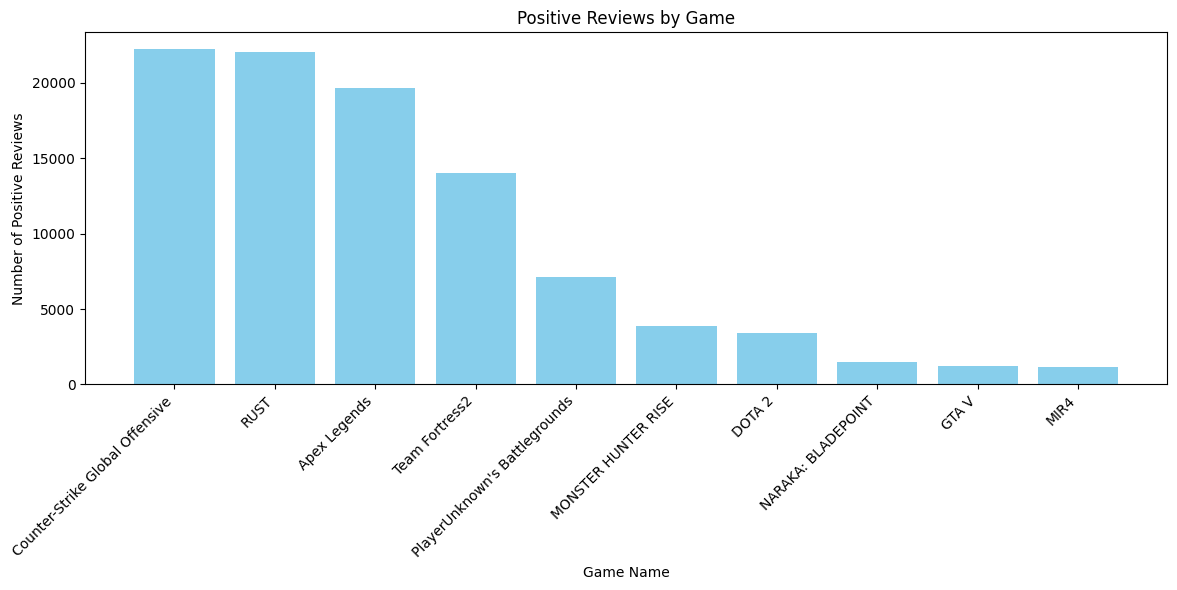

In [16]:
import matplotlib.pyplot as plt

rank_game = rank_game.collect()

# Extract game names and their positive review counts
game_names = [row['Game_Name'] for row in rank_game]
positive_reviews = [row['num_positive_reviews'] for row in rank_game]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(game_names, positive_reviews, color='skyblue')
plt.xlabel('Game Name')
plt.ylabel('Number of Positive Reviews')
plt.title('Positive Reviews by Game')
plt.xticks(rotation=45, ha='right')  # Rotate game names for better visibility
plt.tight_layout()

plt.show()



> *Count how many reviews fall into each sentiment score category for each game*



In [27]:
sentiment_count = long_review.groupBy('Game_Name', 'Sentiment_Score').count().orderBy("Game_Name","Sentiment_Score")
sentiment_count.show()

+--------------------+---------------+-----+
|           Game_Name|Sentiment_Score|count|
+--------------------+---------------+-----+
|        Apex Legends|              0| 2801|
|        Apex Legends|              1|19686|
|Counter-Strike Gl...|              0| 3021|
|Counter-Strike Gl...|              1|22246|
|              DOTA 2|              0| 1010|
|              DOTA 2|              1| 3396|
|               GTA V|              0|  387|
|               GTA V|              1| 1207|
|                MIR4|              0|  486|
|                MIR4|              1| 1137|
| MONSTER HUNTER RISE|              0|  444|
| MONSTER HUNTER RISE|              1| 3906|
|  NARAKA: BLADEPOINT|              0|  322|
|  NARAKA: BLADEPOINT|              1| 1515|
|PlayerUnknown's B...|              0| 3941|
|PlayerUnknown's B...|              1| 7153|
|                RUST|              0| 2471|
|                RUST|              1|22059|
|      Team Fortress2|              0|  958|
|      Tea



> *Use pie chart to show the distribution of sentiment scores for top-3 games*



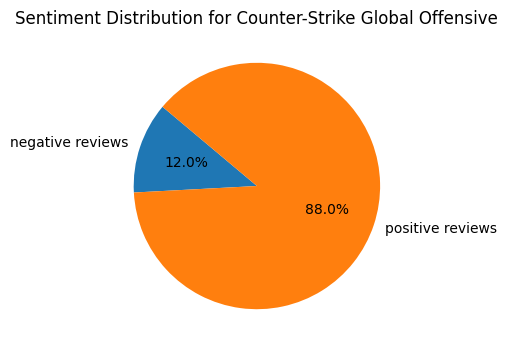

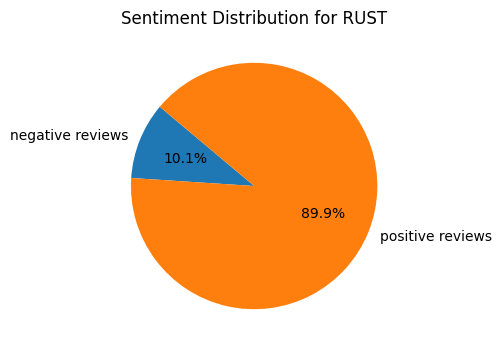

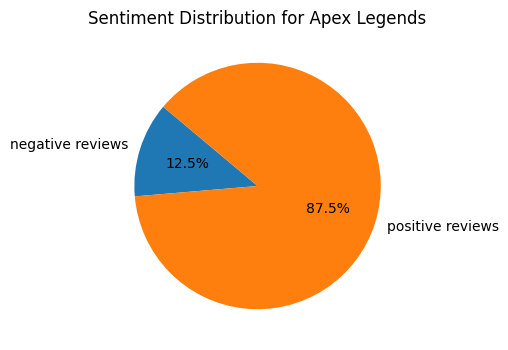

In [32]:
top_three = rank_game[:3]
for game in top_three:
    game_name = game['Game_Name']
    game_data = sentiment_count.filter(sentiment_count['Game_Name'] == game_name).toPandas()
    labels = ['negative reviews','positive reviews']
    # Plot pie chart
    plt.figure(figsize=(4, 4))
    plt.pie(game_data['count'], labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'Sentiment Distribution for {game_name}')
    plt.show()

In [17]:
!pip install wordcloud matplotlib

**Remove stop words from ALL game reviews** ⛳

In [37]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import concat_ws

#Tokenize the Review Text
tokenizer = Tokenizer(inputCol="Review", outputCol="words")
tokenized = tokenizer.transform(long_review)

#Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# Get the default list of stopwords
default_stopwords = remover.getStopWords()

# Add custom stopwords
custom_stopwords = ['game','games','game,','game.','dog','played','also', 'dont', 'people', 'still', 'one', 'play', 'always','lot','players','get','makes','really','ever','got','think','since,','every']
all_stopwords = default_stopwords + custom_stopwords
remover.setStopWords(all_stopwords)
cleaned_review = remover.transform(tokenized)

#Reassemble words back into a single string
cleaned_review_df = cleaned_review.withColumn("cleaned_review", functions.concat_ws(" ", "filtered_words"))
cleaned_review_df = cleaned_review_df.drop("words", "filtered_words").cache()
cleaned_review_df.show(5)

+--------------------+---------------+--------------------+--------------------+--------------------+
|              Review|Sentiment_Score|           Game_Name|     Clean_Game_Name|      cleaned_review|
+--------------------+---------------+--------------------+--------------------+--------------------+
|              peepee|              1|        Apex Legends|         apexlegends|              peepee|
|Painfully horrend...|              0|PlayerUnknown's B...|playerunknownsbat...|painfully horrend...|
|              its ok|              1|        Apex Legends|         apexlegends|                  ok|
|           Nice game|              1|      Team Fortress2|       teamfortress2|                nice|
|they copied many ...|              0|      Team Fortress2|       teamfortress2|copied many thing...|
+--------------------+---------------+--------------------+--------------------+--------------------+
only showing top 5 rows





> *Wordcloud to show frequently used words in ALL reviews*



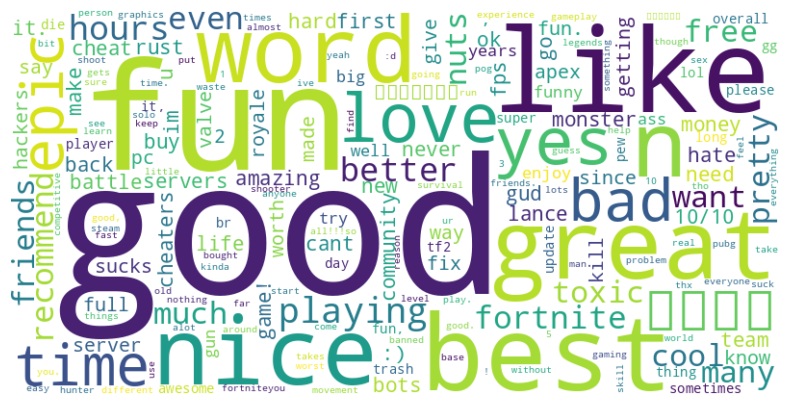

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Tokenize reviews into words
words = cleaned_review_df.withColumn("word", functions.explode(functions.split(functions.col("cleaned_review"), " ")))

# Compute word frequencies
word_freq = words.groupBy("word").count()

# Collect word frequencies to the driver node for visualization
word_freq_local = word_freq.collect()

# Convert the collected word frequencies into a dictionary format
word_freq_dict = {row['word']: row['count'] for row in word_freq_local}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

> *Wordcloud to show frequently used words in POSITIVE reviews*

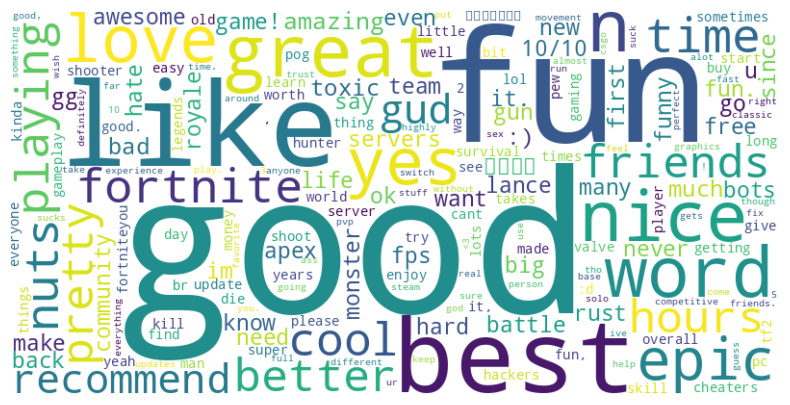

In [39]:
#Keep only positive game reviews
clean_pos_reviews = cleaned_review_df.filter(cleaned_review_df["Sentiment_Score"] == 1).cache()
# Tokenize reviews into words
words = clean_pos_reviews.withColumn("word", functions.explode(functions.split(functions.col("cleaned_review"), " ")))

# Compute word frequencies
word_freq = words.groupBy("word").count()

# Collect word frequencies to the driver node for visualization
word_freq_local = word_freq.collect()

# Convert the collected word frequencies into a dictionary format
word_freq_dict = {row['word']: row['count'] for row in word_freq_local}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



> *Percentage of positive review for each game*



In [40]:
agg_review = cleaned_review_df.groupBy("Game_Name").agg(
                                functions.count("cleaned_review").alias("total_reviews_count"),
                                functions.sum(functions.when(functions.col("Sentiment_Score")==1,1)).alias("positive_reviews_count")
                                #functions.sum(functions.when(functions.col("Sentiment_Score")==0,0)).alias("neagtive_reviews_count")
                                )

result = agg_review.withColumn(
    "positive_percentage",
    (functions.col("positive_reviews_count") / functions.col("total_reviews_count")) * 100
)
result = result.withColumn(
    "negative_reviews_count",
    (functions.col("total_reviews_count") - functions.col("positive_reviews_count"))
)
result = result.withColumn(
    "negative_percentage",
    100-functions.col("positive_percentage")
)

result = result.orderBy(functions.desc("positive_percentage"))
result.show()

+--------------------+-------------------+----------------------+-------------------+----------------------+-------------------+
|           Game_Name|total_reviews_count|positive_reviews_count|positive_percentage|negative_reviews_count|negative_percentage|
+--------------------+-------------------+----------------------+-------------------+----------------------+-------------------+
|      Team Fortress2|               4159|                  3896|  93.67636451069968|                   263|  6.323635489300315|
| MONSTER HUNTER RISE|               1202|                  1083|  90.09983361064891|                   119|  9.900166389351085|
|                RUST|               6610|                  5949|               90.0|                   661|               10.0|
|        Apex Legends|               6149|                  5385|  87.57521548219222|                   764|  12.42478451780778|
|Counter-Strike Gl...|               6898|                  6037|  87.51812119454915|            

> *Graph the percentage of positive and negative review of entire dataset*

In [22]:
!pip install matplotlib pandas

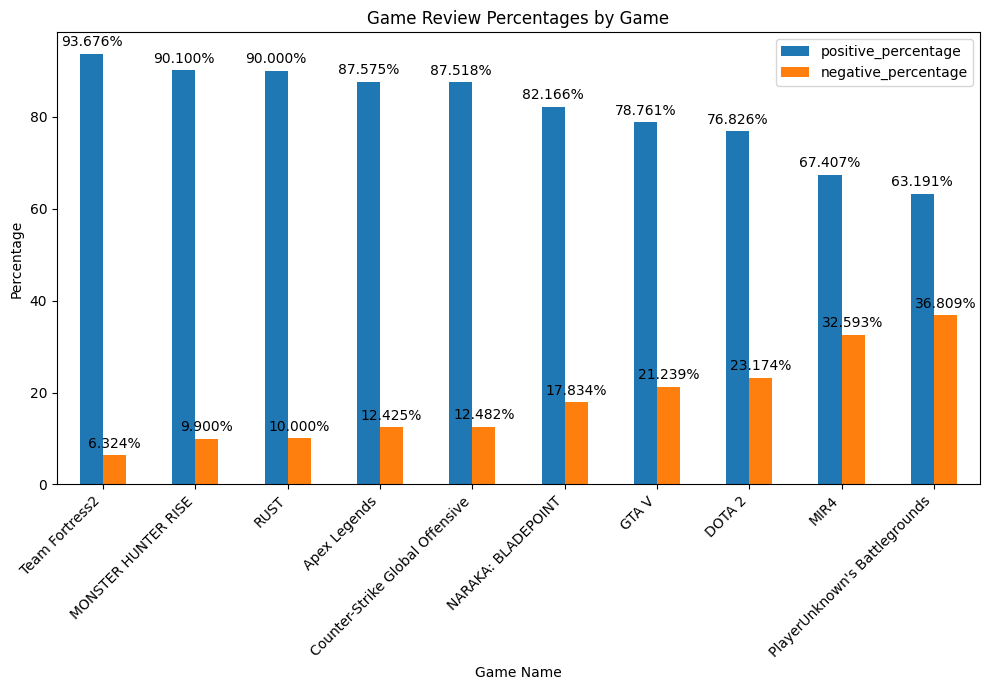

In [41]:
import matplotlib.pyplot as plt

# Convert to the panda dataframe
pd_result = result.toPandas()

# Set the index to be the game names
pd_result.set_index("Game_Name", inplace=True)

# Plotting
bar_chart = pd_result[['positive_percentage', 'negative_percentage']].plot(kind='bar', stacked=False, figsize=(10,7))

plt.title("Game Review Percentages by Game")
plt.ylabel("Percentage")
plt.xlabel("Game Name")
plt.xticks(rotation=45, ha="right")  # Rotate game names for better readability
plt.tight_layout()

# Adding labels
for rect in bar_chart.patches:
    height = rect.get_height()
    bar_chart.text(rect.get_x() + rect.get_width() / 2, height + 1, f'{height:.3f}%', ha='center', va='bottom')

plt.show()



> *Which games have the highest and lowest average sentiment scores?*



In [18]:
classify_review = long_review.groupBy("Game_Name").agg(functions.avg("Sentiment_Score").alias("Avg_Sentiment"))
avg_Sentiment = classify_review.withColumn(
    "Sentiment_Polarity",
    functions.when(functions.col("Avg_Sentiment")>0.5, "Positive").otherwise("Negative")
)
avg_Sentiment.sort("Avg_Sentiment", ascending=False).show()

+--------------------+------------------+------------------+
|           Game_Name|     Avg_Sentiment|Sentiment_Polarity|
+--------------------+------------------+------------------+
|      Team Fortress2|0.9361928866391368|          Positive|
|                RUST|0.8992662046473706|          Positive|
| MONSTER HUNTER RISE|0.8979310344827586|          Positive|
|Counter-Strike Gl...|0.8804369335496893|          Positive|
|        Apex Legends|0.8754391426157335|          Positive|
|  NARAKA: BLADEPOINT|0.8247142079477409|          Positive|
|              DOTA 2|0.7707671357240127|          Positive|
|               GTA V|0.7572145545796738|          Positive|
|                MIR4|0.7005545286506469|          Positive|
|PlayerUnknown's B...|0.6447629349197764|          Positive|
+--------------------+------------------+------------------+



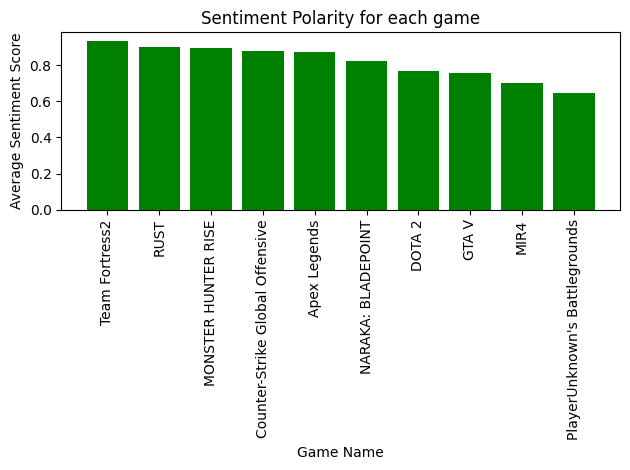

In [24]:
avg_Sentiment_pd = avg_Sentiment.toPandas()
avg_Sentiment_pd = avg_Sentiment_pd.sort_values('Avg_Sentiment', ascending=False)
colors = ['red' if x<0.5 else 'green' for x in avg_Sentiment_pd['Avg_Sentiment']]
plt.bar(avg_Sentiment_pd['Game_Name'], avg_Sentiment_pd['Avg_Sentiment'], color=colors)
plt.xlabel('Game Name')
plt.ylabel('Average Sentiment Score')
plt.title('Sentiment Polarity for each game')
plt.xticks(rotation=90)  # Rotate the game names to fit them along the x-axis
plt.tight_layout()  # Adjust the layout to make room for the x-axis labels

plt.show()



> *Analyze if the length of a review text has any correlation with the sentiment score.*



In [42]:
word_count = long_review.withColumn("num_words", functions.size(functions.split(functions.col("Review")," ")))
correlation = word_count.stat.corr('num_words', 'Sentiment_Score')
print(f"Correlation coefficient: {correlation}")

Correlation coefficient: -0.12852405285566548


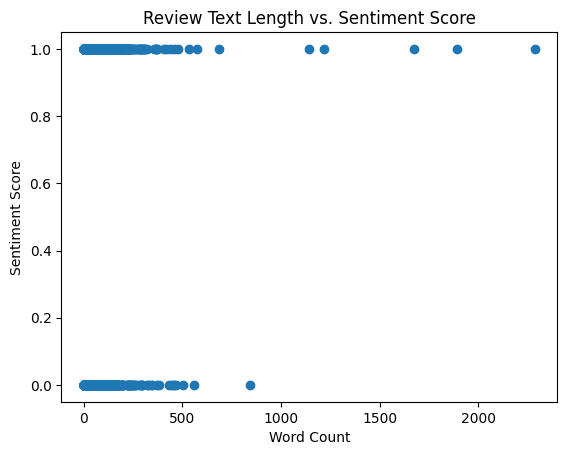

In [43]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = word_count.select('num_words', 'Sentiment_Score').toPandas()

# Create scatter plot
plt.scatter(pandas_df['num_words'], pandas_df['Sentiment_Score'])
plt.title('Review Text Length vs. Sentiment Score')
plt.xlabel('Word Count')
plt.ylabel('Sentiment Score')
plt.show()



> *Calculated the correlation coefficient between number of words in review with its sentiment score for each game*



In [44]:
words = long_review.withColumn("num_words", functions.size(functions.split(functions.col("Review")," ")))
grouped_df = words.groupBy("Game_Name")
correlations = { }

for game in words.select('Game_Name').distinct().rdd.flatMap(lambda x: x).collect():
    game_df = words.filter(words['Game_Name'] == game)
    correlation = game_df.stat.corr('num_words', 'Sentiment_Score')
    correlations[game] = correlation

print(correlations)

{'RUST': -0.11872641205343365, 'MIR4': -0.30269238196212434, 'NARAKA: BLADEPOINT': -0.24320858690609415, "PlayerUnknown's Battlegrounds": -0.2119338464248907, 'Apex Legends': -0.13165654334939775, 'Team Fortress2': -0.08694151557203575, 'MONSTER HUNTER RISE': -0.09156485696052755, 'Counter-Strike Global Offensive': -0.08766671876455312, 'DOTA 2': -0.22420145103317277, 'GTA V': -0.2415784138856044}
